
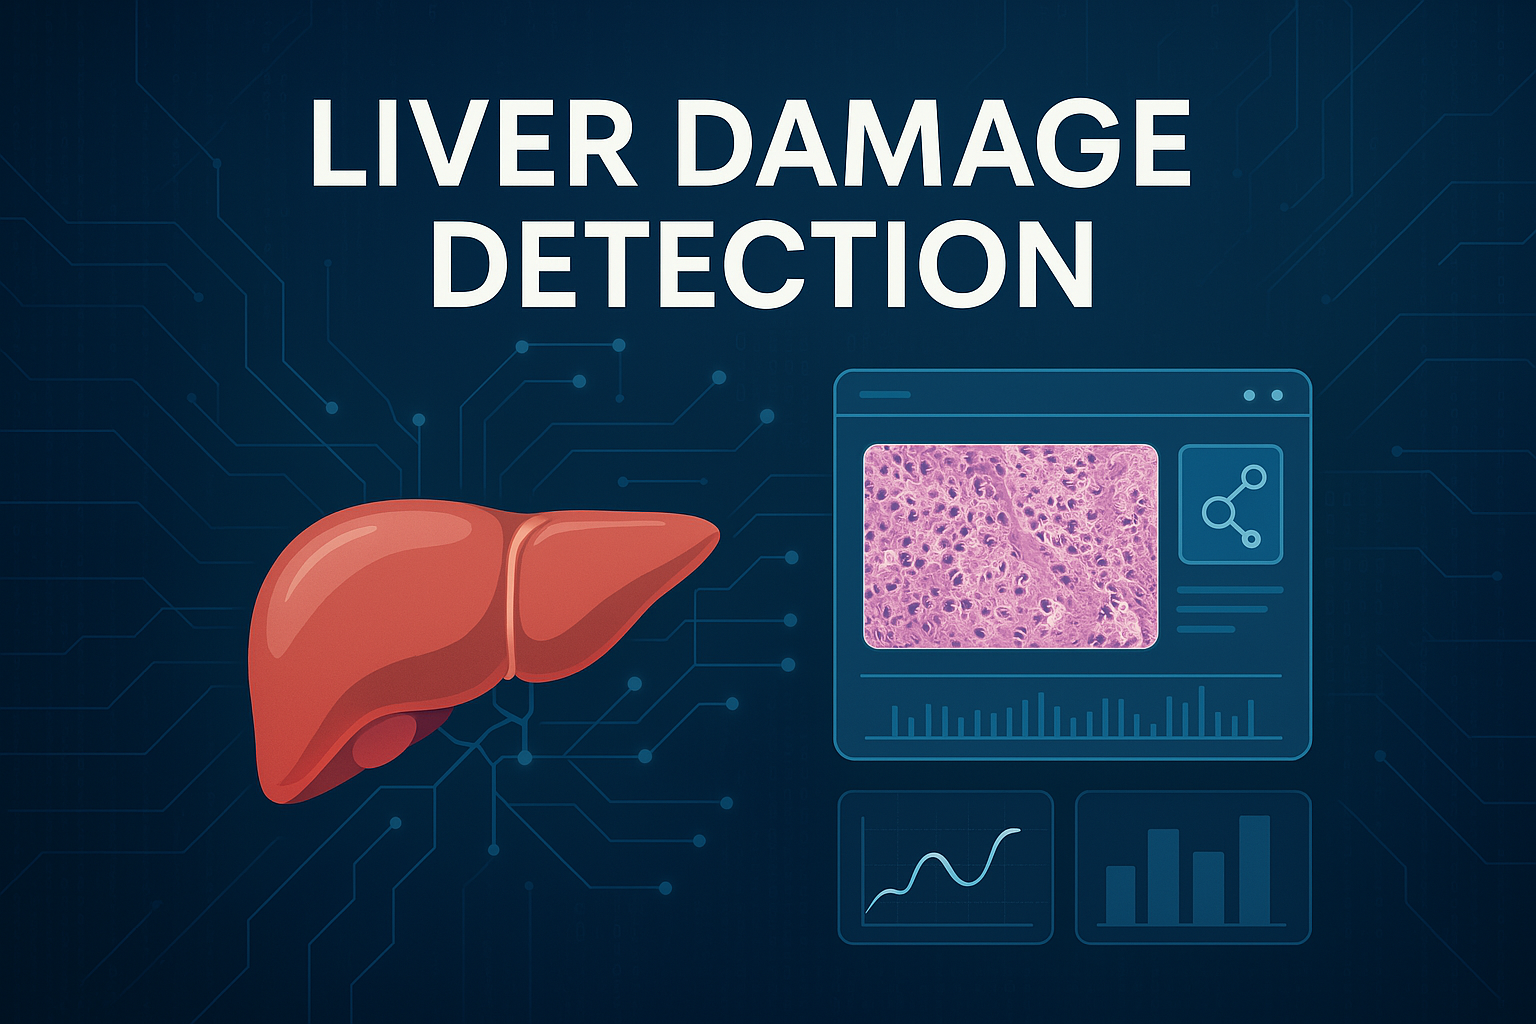

**BUSINESS PROBLEM:**

Current liver damage detection relies heavily on manual analysis by hepatologists, making early diagnosis and risk assessment time-consuming and prone to human error. By leveraging Al-driven models to analyze histopathology images and patient healthcare data, we can provide detailed insights to assist hepatologists in making more accurate and timely decisions for early intervention.

**Business Objective**: Maximize early detection accuracy.

**Business Constraints**: Minimize false positive/negative rates.

**Success criteria:**
**Business Success Criteria**: Reduce manual efforts in liver damage assessment by 20-30% through Al- driven insights.

**ML Success Criteria**: Achieve a prediction accuracy more than 85% in detecting liver damage.

**Economic Success Criteria**: Achieve at least a 15% cost reduction in diagnosis by minimizing errors and optimizing workflows.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **EDA Steps for Histopathology Images**

#🔹 4. Intensity Distribution

Plot pixel intensity histogram (R, G, B) for a few images.

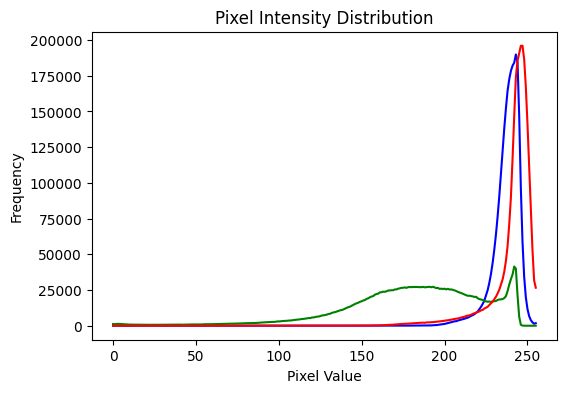

In [ ]:
def plot_intensity_histogram(img_path):
    img = cv2.imread(img_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

# Try with one image
sample_path = os.path.join(data_dir, 'HCC', os.listdir(os.path.join(data_dir, 'HCC'))[0])
plot_intensity_histogram(sample_path)


#🔹 5. Color Mean & Standard Deviation (Per Class)
Compare brightness/contrast between different classes.

In [ ]:
import numpy as np

def compute_color_stats_per_class(data_dir):
    stats = {}
    for cls in os.listdir(data_dir):
        img_paths = [os.path.join(data_dir, cls, img) for img in os.listdir(os.path.join(data_dir, cls))]
        means, stds = [], []
        for path in img_paths:
            img = cv2.imread(path)
            img = img.astype('float32') / 255.0
            means.append(np.mean(img, axis=(0, 1)))
            stds.append(np.std(img, axis=(0, 1)))
        stats[cls] = {
            "Mean": np.mean(means, axis=0),
            "Std Dev": np.mean(stds, axis=0)
        }
    return stats

stats = compute_color_stats_per_class("processed_dataset")
for cls, val in stats.items():
    print(f"\n📁 Class: {cls}")
    print(f"🔹 Mean RGB: {val['Mean']}")
    print(f"🔹 Std Dev RGB: {val['Std Dev']}")



📁 Class: HCC
🔹 Mean RGB: [0.77074707 0.53275675 0.7719087 ]
🔹 Std Dev RGB: [0.19475166 0.23538204 0.21452984]

📁 Class: CC
🔹 Mean RGB: [0.7173819  0.5339946  0.72312874]
🔹 Std Dev RGB: [0.19179647 0.21340536 0.20211734]

📁 Class: NORMAL LIVER
🔹 Mean RGB: [0.67042655 0.44038722 0.69617397]
🔹 Std Dev RGB: [0.19050136 0.18934241 0.20007013]


# 📂 Optional: Export Summary Report

You can also write all stats to a CSV or TXT file if needed.

In [ ]:
with open("eda_summary.txt", "w") as f:
    for cls, val in stats.items():
        f.write(f"Class: {cls}\n")
        f.write(f"Mean RGB: {val['Mean']}\n")
        f.write(f"Std Dev RGB: {val['Std Dev']}\n\n")


(1)    **EDA**

✅ **(1) Load Dataset**

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy import stats

# Path to dataset folder
data_dir = '/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/DataSet'

classes = os.listdir(data_dir)

# Create a dataframe to store metadata
image_data = []

for label in classes:
    class_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                img_array = np.array(img.convert('L'))  # Convert to grayscale
                intensity_flat = img_array.flatten()
                mean_intensity = intensity_flat.mean()
                median_intensity = np.median(intensity_flat)
                mode_intensity = stats.mode(intensity_flat, axis=None, keepdims=False).mode
                aspect_ratio = width / height
                image_data.append([
                    img_file, label, width, height, aspect_ratio,
                    mean_intensity, median_intensity, mode_intensity
                ])
        except:
            print(f"Skipping corrupted image: {img_path}")

# Create DataFrame
df = pd.DataFrame(image_data, columns=[
    'Filename', 'Class', 'Width', 'Height', 'Aspect_Ratio',
    'Mean_Intensity', 'Median_Intensity', 'Mode_Intensity'
])

df.head()


Filename Class  Width  Height  Aspect_Ratio  Mean_Intensity  \
0  140_filtered.jpg    CC   1539     916      1.680131      184.236458   
1    71_shifted.jpg    CC   1600    1138      1.405975      180.760548   
2   108_shifted.jpg    CC    685     451      1.518847      136.107197   
3  108_filtered.jpg    CC    685     451      1.518847      152.201088   
4    81_shifted.jpg    CC   2448    1920      1.275000      146.381626   

   Median_Intensity  Mode_Intensity  
0             186.0             201  
1             194.0               0  
2             153.0               0  
3             158.0             171  
4             152.0               0

**✅ (2) EDA for Each Class**

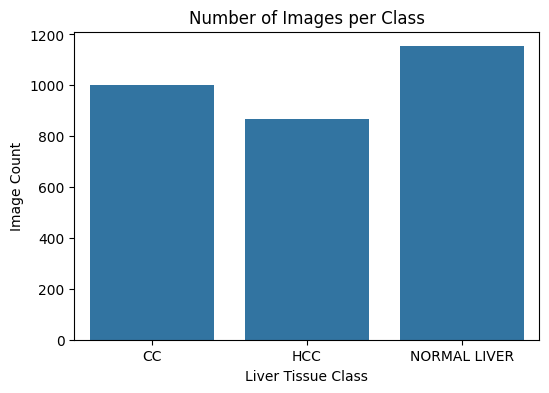

In [ ]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Number of Images per Class')
plt.xlabel('Liver Tissue Class')
plt.ylabel('Image Count')
plt.show()


In [ ]:
# Step 3: Undersample majority classes
# Get the minimum count of samples per class
min_count = df['Class'].value_counts().min()

# Undersample to balance the dataset
balanced_df = pd.concat([
    df[df['Class'] == cls].sample(min_count, random_state=42)
    for cls in df['Class'].unique()
])

In [ ]:
# Check Balanced or Not
import os
import shutil
import random
from pathlib import Path

# Path to your original dataset
dataset_path = Path('/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/DataSet')  # change if needed

# Count files in each class
class_counts = {folder.name: len(list(folder.glob('*'))) for folder in dataset_path.iterdir() if folder.is_dir()}
print("📊 Class Distribution BEFORE balancing:\n", class_counts)

# Get minimum count for balancing
min_count = min(class_counts.values())
print(f"\n⚖️ Balancing all classes to {min_count} samples...")

# Output path for balanced data
balanced_path = Path('/content/balanced_dataset')
shutil.rmtree(balanced_path, ignore_errors=True)
balanced_path.mkdir(parents=True, exist_ok=True)

# Undersample and copy files
for class_name, count in class_counts.items():
    class_dir = dataset_path / class_name
    balanced_class_dir = balanced_path / class_name
    balanced_class_dir.mkdir(parents=True, exist_ok=True)

    # Randomly select min_count files
    selected_files = random.sample(list(class_dir.glob('*')), min_count)

    for file_path in selected_files:
        shutil.copy(file_path, balanced_class_dir)

# Check new class distribution
new_counts = {folder.name: len(list(folder.glob('*'))) for folder in balanced_path.iterdir() if folder.is_dir()}
print("\n✅ Class Distribution AFTER balancing:\n", new_counts)


📊 Class Distribution BEFORE balancing:
 {'CC': 1000, 'HCC': 869, 'NORMAL LIVER': 1153}

⚖️ Balancing all classes to 869 samples...

✅ Class Distribution AFTER balancing:
 {'CC': 869, 'HCC': 869, 'NORMAL LIVER': 869}


**Download the balanced dataset as ZIP**

In [ ]:
# Zip the balanced folder
shutil.make_archive('balanced_dataset', 'zip', '/content/balanced_dataset')

# Download the zip file
from google.colab import files
files.download('balanced_dataset.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil # Import the shutil module to access the copy function
import os
# Optional: Save balanced dataset to new folders
balanced_dir = 'balanced_dataset'
if not os.path.exists(balanced_dir):
    os.makedirs(balanced_dir)

for cls in classes:
    os.makedirs(os.path.join(balanced_dir, cls), exist_ok=True)

for _, row in balanced_df.iterrows():
    # Assuming your DataFrame has a column named 'Filename' or 'Path'
    # that contains the path to the source image file.
    # Replace 'Filename' with the actual column name if it's different.
    # This section was unindented. Indenting fixes the error.
    source_path = row.get('Path', row['Filename'])  # Try 'Path' first, fallback to 'Filename'
    dest_path = os.path.join(balanced_dir, row['Class'], os.path.basename(source_path))
    #copyfile(source_path, dest_path) # Assuming 'copyfile' is imported.

**✅ (3) Intensity Distribution**

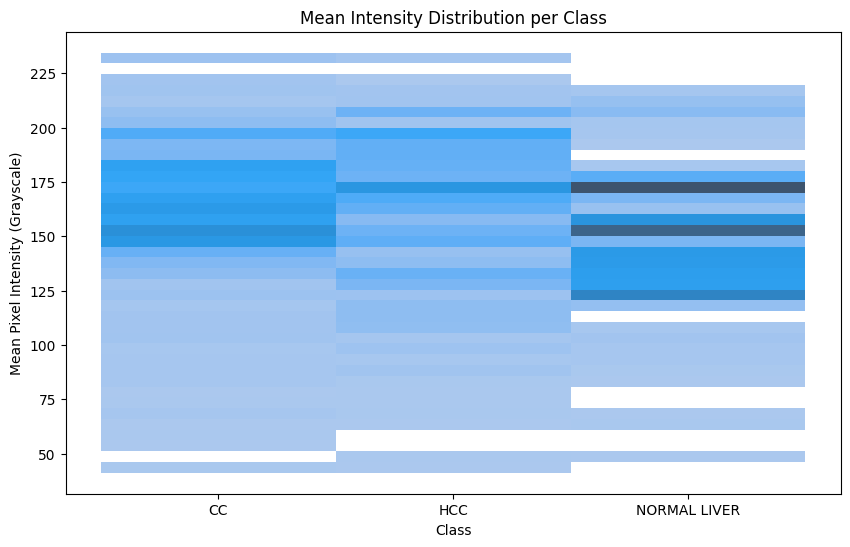

In [ ]:
# Intensity distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Class', y='Mean_Intensity')
plt.title('Mean Intensity Distribution per Class')
plt.xlabel('Class')
plt.ylabel('Mean Pixel Intensity (Grayscale)')
plt.show()


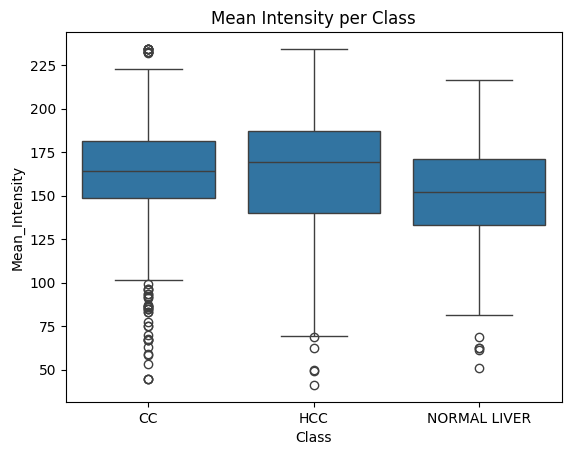

In [ ]:
# 1. Boxplot of intensities per class
sns.boxplot(x='Class', y='Mean_Intensity', data=df)
plt.title('Mean Intensity per Class')
plt.show()

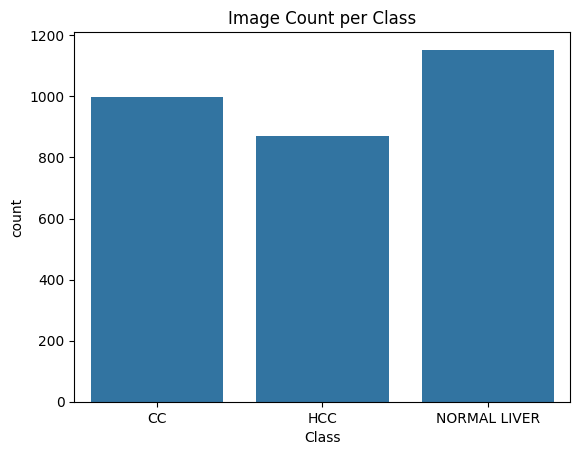

In [ ]:
# 2. Class distribution
sns.countplot(x='Class', data=df)
plt.title('Image Count per Class')
plt.show()

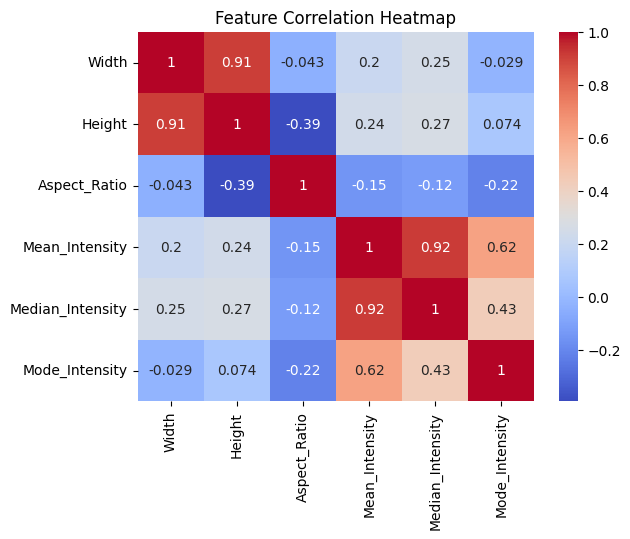

In [ ]:
# 3. Correlation heatmap
sns.heatmap(df[['Width', 'Height', 'Aspect_Ratio', 'Mean_Intensity', 'Median_Intensity', 'Mode_Intensity']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

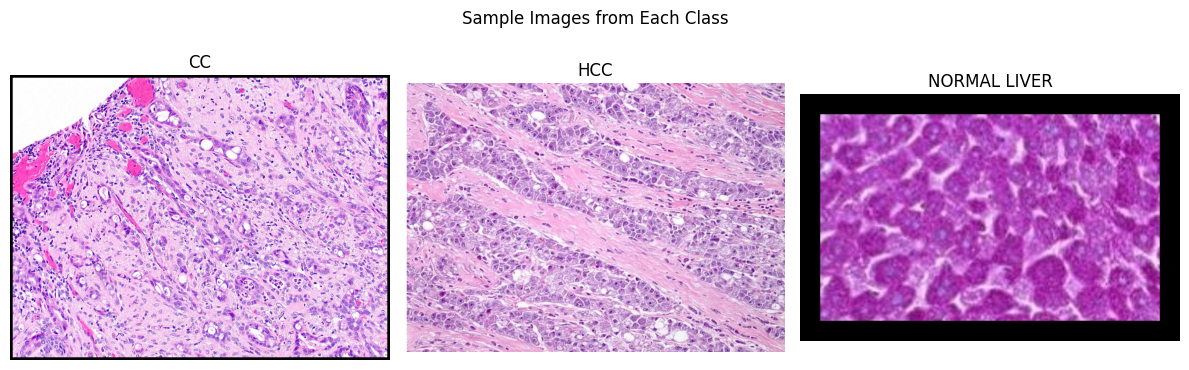

In [ ]:
# 4. Grid of images per class
import random
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(df['Class'].unique()):
    sample_file = random.choice(df[df['Class'] == label]['Filename'].values)
    path = os.path.join(data_dir, label, sample_file)
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')
plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()

**✅ (4) Aspect Ratio & Insights**

📐 Why Check Aspect Ratio in Image Datasets?

⚠️ 1. Aspect Ratio Impacts Model Performance
Aspect ratio = Width / Height of the image.

If images across classes have very different shapes, your model might learn shape/size patterns instead of real features (e.g., tissue structures).

For example, if HCC images are mostly wide and Normal are tall, your model might cheat and learn that instead of learning actual liver cell patterns. That's called data leakage or bias.

📊 2. Quality Check & Preprocessing
By plotting the aspect ratio (as you did with a violin plot), you're checking:

Are all images consistently shaped?

Are there outliers (very stretched or squished images)?

This helps you standardize image dimensions, like resizing to (224x224) or padding images without distorting them.

🔍 3. Violin Plot Insight
Your sns.violinplot() shows how the distribution of aspect ratios varies across HCC, CC, and Normal Liver.

If distributions are very different, you may consider:

Resizing all images while maintaining aspect ratio (with padding)

Or forcing a fixed aspect ratio (may lose detail)

✨ BONUS: Why You Also Checked Mean Intensity
Mean intensity gives an idea of brightness or tissue density.

Variations here can show differences in staining, scanner settings, or cell structure—useful for further feature engineering.

✅ In Short:
You checked aspect ratio to ensure image shape consistency, avoid biases or shortcuts in model learning, and to improve model generalization.

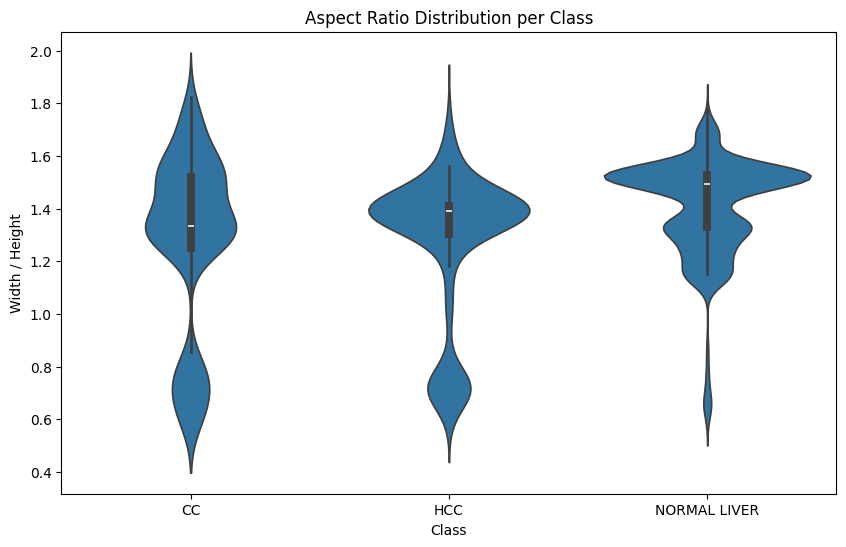

Aspect Ratio Summary:
               count      mean       std       min       25%       50%  \
Class                                                                    
CC            1000.0  1.281041  0.333528  0.564545  1.250000  1.333333   
HCC            869.0  1.273752  0.278023  0.580981  1.303538  1.391863   
NORMAL LIVER  1153.0  1.407053  0.189762  0.593190  1.328990  1.494643   

                   75%       max  
Class                             
CC            1.518847  1.824441  
HCC           1.409091  1.803419  
NORMAL LIVER  1.527273  1.780069  

Mean Intensity Summary:
               count        mean        std        min         25%  \
Class                                                                
CC            1000.0  163.186690  28.815529  44.478165  148.599836   
HCC            869.0  162.061795  32.619215  41.188258  139.933333   
NORMAL LIVER  1153.0  151.045482  23.900881  50.993930  133.097453   

                     50%         75%         max  
Class

In [ ]:
# Aspect Ratio Distribution
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='Class', y='Aspect_Ratio', inner='box')
plt.title('Aspect Ratio Distribution per Class')
plt.xlabel('Class')
plt.ylabel('Width / Height')
plt.show()

# Insights
print("Aspect Ratio Summary:")
print(df.groupby('Class')['Aspect_Ratio'].describe())

print("\nMean Intensity Summary:")
print(df.groupby('Class')['Mean_Intensity'].describe())


**✅ (5) Parameters For Analysis**

💡 Parameters Used in Histopathology EDA Parameter	Description

Width & Height	Dimensions of each image

Aspect Ratio	Width / Height, used to analyze resizing needs

Mean Intensity	Average grayscale intensity per image

Class	Label/category of image

Pixel Stats	Mean and StdDev of intensity and aspect ratio

In [ ]:
summary_stats = df.groupby('Class').agg({
    'Width': ['mean', 'std'],
    'Height': ['mean', 'std'],
    'Aspect_Ratio': ['mean', 'std'],
    'Mean_Intensity': ['mean', 'std']
}).round(2)

summary_stats.columns = ['_'.join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)
print(summary_stats)


          Class  Width_mean  Width_std  Height_mean  Height_std  \
0            CC     1231.33     692.12      1013.42      601.98   
1           HCC      901.55     478.73       736.14      409.65   
2  NORMAL LIVER      459.75     221.67       340.15      192.21   

   Aspect_Ratio_mean  Aspect_Ratio_std  Mean_Intensity_mean  \
0               1.28              0.33               163.19   
1               1.27              0.28               162.06   
2               1.41              0.19               151.05   

   Mean_Intensity_std  
0               28.82  
1               32.62  
2               23.90  


**🔍 Additional Visualization (Optional)**

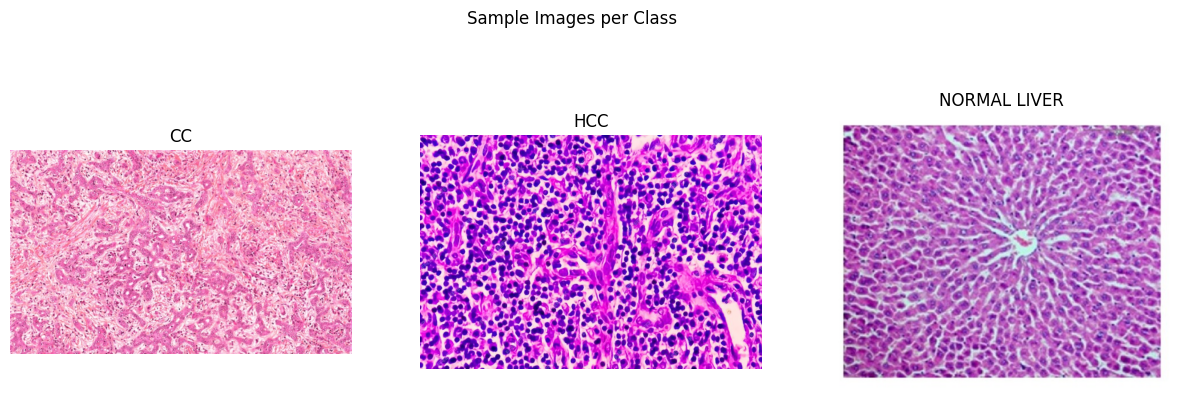

In [ ]:
# Sample images per class
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, label in zip(axes, classes):
    class_dir = os.path.join(data_dir, label)
    sample_image = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, sample_image)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.suptitle("Sample Images per Class")
plt.show()


---------------  **IMPORTING NECESSARY LIBRARIES**  -----------

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
from zipfile import ZipFile # Import ZipFile for creating zip archives
import shutil # Import the shutil module
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# The following line was indented but should not have been
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

-------------------------  **Data Preprocessing Steps**  -----------------------

In [ ]:
# -------- Configuration --------
input_dir = "/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/balanced_dataset"  # 🔁 Replace with balance dataset directory (containing HCC, CC, NORMAL LIVER)
output_dir = "processed_dataset"

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tqdm import tqdm

# -------- Configuration --------
input_dir = "/content/drive/MyDrive/PROJECT/LIVER DAMAGE DETECTION/balanced_dataset"  # Make sure this has 869 images per class
output_dir = "processed_dataset"
os.makedirs(output_dir, exist_ok=True)

classes = os.listdir(input_dir)
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# -------- Data Augmentation Config (just 1 variant) --------
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# -------- Process Each Image --------
for cls in classes:
    class_path = os.path.join(input_dir, cls)
    save_path = os.path.join(output_dir, cls)

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {cls}"):
        img_path = os.path.join(class_path, img_name)

        # Step 1: Load image
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable images
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Step 2: Save Original
        base_filename = os.path.splitext(img_name)[0]
        cv2.imwrite(os.path.join(save_path, f"{base_filename}_original.jpg"), img)

        # Step 3: Augment (only 1 variant)
        img_array = img_to_array(img_rgb) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_image = next(aug_iter)[0]  # shape: (H, W, 3), scaled between 0-1
        aug_image_uint8 = (aug_image * 255).astype("uint8")

        # Step 4: Save augmented
        cv2.imwrite(os.path.join(save_path, f"{base_filename}_augmented.jpg"), cv2.cvtColor(aug_image_uint8, cv2.COLOR_RGB2BGR))

print("✅ All images processed and saved with only 1 augmentation per original.")


Processing CC:  19%|█▉        | 164/869 [01:31<06:32,  1.80it/s]


KeyboardInterrupt: 

In [3]:
import os
# Path to the processed dataset
processed_dir = "/content/drive/MyDrive/Colab Notebooks/Processed dataset"

# Dictionary to hold class-wise image counts
class_counts = {}

# Count images in each class folder
for cls in os.listdir(processed_dir):
    class_path = os.path.join(processed_dir, cls)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))])
        class_counts[cls] = image_count

# Display class-wise counts
print("📦 Processed Image Counts per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Total images
total_images = sum(class_counts.values())
print(f"\n🧮 Total Processed Images: {total_images}")


📦 Processed Image Counts per Class:
CC: 1738 images
HCC: 1747 images
NORMAL LIVER: 1738 images

🧮 Total Processed Images: 5223


In [ ]:
import shutil

# Zip the folder
shutil.make_archive("processed_dataset", 'zip', "processed_dataset")


'/content/processed_dataset.zip'

**Split Model**

**✅ Part 1: Train-Test-Validation Split (70-20-10)**

In [4]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Paths
processed_dir = "/content/drive/MyDrive/Colab Notebooks/Processed dataset"
split_base_dir = "/content/split_dataset"
os.makedirs(split_base_dir, exist_ok=True)

# Ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Clear any existing splits
for split in ['train', 'test', 'val']:
    split_path = os.path.join(split_base_dir, split)
    if os.path.exists(split_path):
        shutil.rmtree(split_path)
    os.makedirs(split_path)

# Splitting
for cls in os.listdir(processed_dir):
    class_path = os.path.join(processed_dir, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

    train_imgs, testval_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    test_imgs, val_imgs = train_test_split(testval_imgs, test_size=(val_ratio / (test_ratio + val_ratio)), random_state=42)

    for split_name, split_imgs in zip(['train', 'test', 'val'], [train_imgs, test_imgs, val_imgs]):
        split_class_dir = os.path.join(split_base_dir, split_name, cls)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_class_dir, img))

print("✅ Data successfully split into Train (70%), Test (20%), and Validation (10%).")


✅ Data successfully split into Train (70%), Test (20%), and Validation (10%).


**✅ Part 2: Model Building Using Pre-trained Models**

DenseNet121

ResNet50

ResNet101 (ResNet151 doesn't exist — likely meant ResNet101 or ResNet152)

ResNet152

VGG16

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50, ResNet101, ResNet152, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = os.path.join(split_base_dir, '/content/split_dataset/train')
val_dir = os.path.join(split_base_dir, '/content/split_dataset/val')
test_dir = os.path.join(split_base_dir, '/content/split_dataset/test')

# Data Generators
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)

def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


Found 3654 images belonging to 3 classes.
Found 523 images belonging to 3 classes.
Found 1046 images belonging to 3 classes.


**🔧 Helper Function to Plot Accuracy**

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [7]:
def plot_accuracy(history, model_name, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy (Epochs: {epochs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


✅ Train All 5 Models

In [8]:
# 📦 Import necessary libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 🔧 Initialize pre-trained models with ImageNet weights (excluding top layer)
models_to_train = {
    "DenseNet121": DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet101": ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet152": ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Train for 10 epochs**

In [ ]:
results_10_epoch = {}

# 🚀 Loop through each model and train for 10 epochs
for name, base_model in models_to_train.items():
    print(f"\n🧠 Training {name} for 10 epochs")

    base_model.trainable = False  # Freeze pre-trained layers

    model = build_model(base_model)  # 🏗️ Build your custom model on top

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # ⏳ Early stopping to prevent overfitting
    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # 🧪 Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[es],
        verbose=1
    )

    # 📊 Evaluate on training, validation, and test sets
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)

    # 📈 Store results
    results_10_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    print(f"✅ {name} -> Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

🧠 Training DenseNet121 for 10 epochs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 99s 619ms/step - accuracy: 0.4111 - loss: 1.4259 - val_accuracy: 0.5211 - val_loss: 0.9675
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - accuracy: 0.4499 - loss: 1.2311 - val_accuracy: 0.6149 - val_loss: 0.8673
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 51s 445ms/step - accuracy: 0.5246 - loss: 1.0800 - val_accuracy: 0.6494 - val_loss: 0.7937
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.5266 - loss: 1.0377 - val_accuracy: 0.6801 - val_loss: 0.7388
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 84s 400ms/step - accuracy: 0.5545 - loss: 0.9767 - val_accuracy: 0.7184 - val_loss: 0.6957
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 387ms/step - accuracy: 0.6122 - loss: 0.8749 - val_accuracy: 0.7529 - val_loss: 0.6585
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.6278 - loss: 0.8324 - val_accuracy: 0.7701 - val_loss: 0.6290
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - accuracy: 0.6379 - loss: 0

**Train for 15 epochs**


🧠 Training DenseNet121 for 15 epochs
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 518ms/step - accuracy: 0.3549 - loss: 1.4641 - val_accuracy: 0.5096 - val_loss: 0.9838
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 374ms/step - accuracy: 0.4626 - loss: 1.1774 - val_accuracy: 0.6188 - val_loss: 0.8599
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 378ms/step - accuracy: 0.5050 - loss: 1.0903 - val_accuracy: 0.6724 - val_loss: 0.7800
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 365ms/step - accuracy: 0.5326 - loss: 1.0346 - val_accuracy: 0.7184 - val_loss: 0.7247
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5841 - loss: 0.9281 - val_accuracy: 0.7395 - val_loss: 0.6800
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.6081 - loss: 0.8786 - val_accuracy: 0.7548 - val_loss: 0.6457
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.6333 - loss: 0.8245 - val_accuracy: 0.7663 - val_loss: 0.6145
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 3

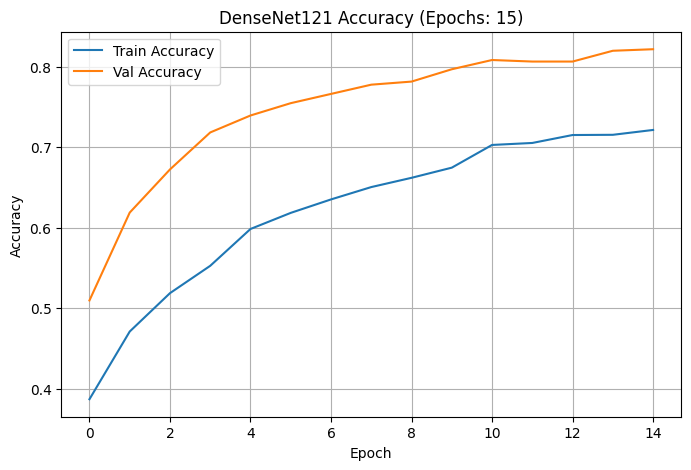

✅ DenseNet121 (15 Epochs) -> Train: 0.8410, Val: 0.8218, Test: 0.8228

🧠 Training ResNet50 for 15 epochs
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 58s 410ms/step - accuracy: 0.3473 - loss: 1.2279 - val_accuracy: 0.3352 - val_loss: 1.0886
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.3603 - loss: 1.1786 - val_accuracy: 0.4713 - val_loss: 1.0698
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.3595 - loss: 1.1527 - val_accuracy: 0.4751 - val_loss: 1.0532
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.3847 - loss: 1.1102 - val_accuracy: 0.5364 - val_loss: 1.0380
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.3873 - loss: 1.1024 - val_accuracy: 0.5268 - val_loss: 1.0272
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - accuracy: 0.4239 - loss: 1.0717 - val_accuracy: 0.5900 - val_loss: 1.0146
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 365ms/step - accuracy: 0.4330 - loss: 1.0611 - val_accuracy: 0.53

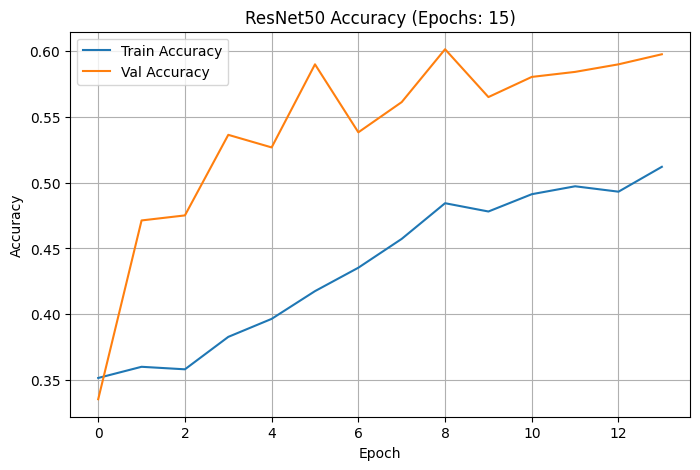

✅ ResNet50 (15 Epochs) -> Train: 0.5872, Val: 0.6015, Test: 0.6025

🧠 Training ResNet101 for 15 epochs
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 83s 566ms/step - accuracy: 0.3460 - loss: 1.3336 - val_accuracy: 0.5307 - val_loss: 1.0806
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 50s 436ms/step - accuracy: 0.3467 - loss: 1.2186 - val_accuracy: 0.5881 - val_loss: 1.0617
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 75s 377ms/step - accuracy: 0.3514 - loss: 1.1818 - val_accuracy: 0.5364 - val_loss: 1.0474
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 45s 397ms/step - accuracy: 0.3893 - loss: 1.1317 - val_accuracy: 0.5460 - val_loss: 1.0339
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 384ms/step - accuracy: 0.3944 - loss: 1.0996 - val_accuracy: 0.5996 - val_loss: 1.0225
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.4203 - loss: 1.0692 - val_accuracy: 0.6015 - val_loss: 1.0123
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.4211 - loss: 1.0681 - val_accuracy: 0.5939

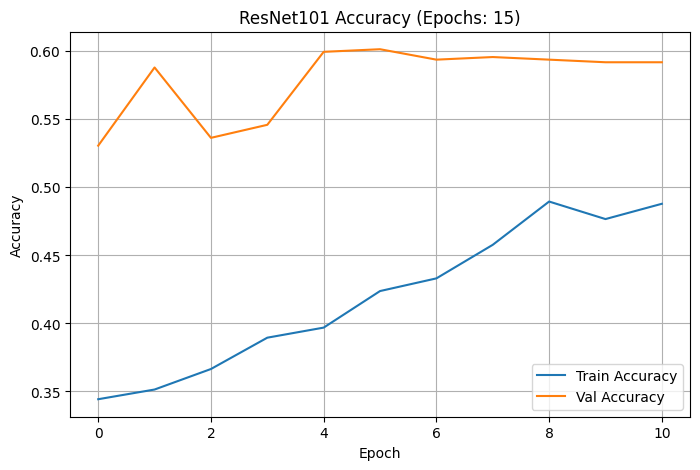

✅ ResNet101 (15 Epochs) -> Train: 0.5877, Val: 0.6015, Test: 0.5900

🧠 Training ResNet152 for 15 epochs
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 89s 538ms/step - accuracy: 0.3190 - loss: 1.4347 - val_accuracy: 0.4330 - val_loss: 1.0815
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 46s 407ms/step - accuracy: 0.3300 - loss: 1.2659 - val_accuracy: 0.4540 - val_loss: 1.0713
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 418ms/step - accuracy: 0.3409 - loss: 1.2251 - val_accuracy: 0.4885 - val_loss: 1.0610
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 46s 407ms/step - accuracy: 0.3787 - loss: 1.1620 - val_accuracy: 0.4138 - val_loss: 1.0540
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.3641 - loss: 1.1527 - val_accuracy: 0.5019 - val_loss: 1.0472
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 46s 405ms/step - accuracy: 0.3756 - loss: 1.1145 - val_accuracy: 0.5000 - val_loss: 1.0415
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 47s 408ms/step - accuracy: 0.4063 - loss: 1.0882 - val_accuracy: 0.475

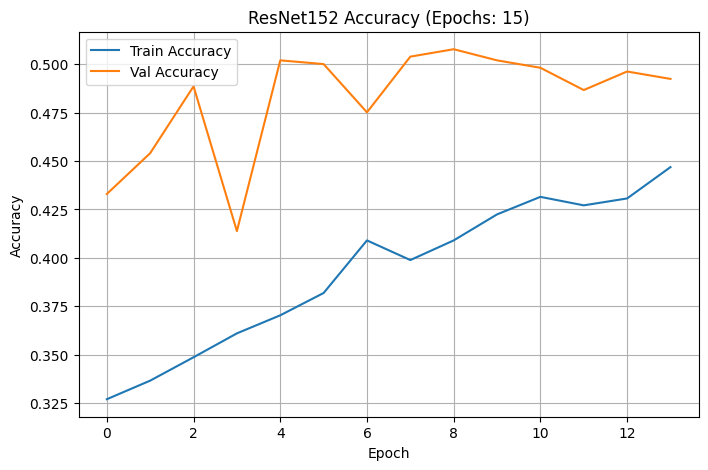

✅ ResNet152 (15 Epochs) -> Train: 0.4767, Val: 0.5077, Test: 0.4914

🧠 Training VGG16 for 15 epochs
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 397ms/step - accuracy: 0.3470 - loss: 1.1952 - val_accuracy: 0.4559 - val_loss: 1.0701
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 388ms/step - accuracy: 0.3527 - loss: 1.1588 - val_accuracy: 0.5192 - val_loss: 1.0449
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 384ms/step - accuracy: 0.4171 - loss: 1.0900 - val_accuracy: 0.5651 - val_loss: 1.0229
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 387ms/step - accuracy: 0.4359 - loss: 1.0773 - val_accuracy: 0.6169 - val_loss: 1.0021
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.4467 - loss: 1.0577 - val_accuracy: 0.6264 - val_loss: 0.9835
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 381ms/step - accuracy: 0.4641 - loss: 1.0358 - val_accuracy: 0.6284 - val_loss: 0.9664
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 384ms/step - accuracy: 0.4782 - loss: 1.0246 - val_accuracy: 0.6226 - 

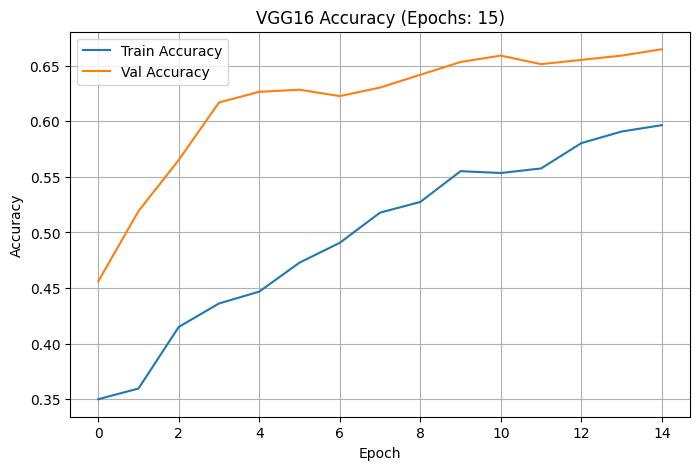

✅ VGG16 (15 Epochs) -> Train: 0.6828, Val: 0.6648, Test: 0.6858


In [ ]:
results_15_epoch = {}

for name, base_model in models_to_train.items():
    print(f"\n🧠 Training {name} for 15 epochs")

    base_model.trainable = False  # Freeze pretrained layers

    model = build_model(base_model)  # Your custom classifier on top

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # ⏳ Early stopping
    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # 🧪 Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=15,
        callbacks=[es],
        verbose=1
    )

    # 📊 Evaluation
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)

    # 💾 Store results
    results_15_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    # 📈 Plot accuracy
    plot_accuracy(history, name, 15)

    print(f"✅ {name} (15 Epochs) -> Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


**Train for 30 epochs**

In [ ]:
!pip install tensorflow

In [ ]:
# 📦 Import necessary libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2


In [ ]:
results_30_epoch = {}

for name, base_model in models_to_train.items():
    print(f"\n🧠 Training {name} for 30 epochs")

    base_model.trainable = False

    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        callbacks=[es],
        verbose=1
    )

    # Accuracy Evaluation
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)

    results_30_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    # Plotting Accuracy
    plot_accuracy(history, name, 30)

    print(f"✅ {name} (30 Epochs) -> Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


NameError: name 'models_to_train' is not defined

**Train for 50 epochs**


🧠 Training DenseNet121 for 50 epochs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 120s 763ms/step - accuracy: 0.3467 - loss: 1.5697 - val_accuracy: 0.4398 - val_loss: 1.0435
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 421ms/step - accuracy: 0.3975 - loss: 1.3156 - val_accuracy: 0.5507 - val_loss: 0.8993
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 405ms/step - accuracy: 0.4849 - loss: 1.1180 - val_accuracy: 0.6348 - val_loss: 0.8043
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.5062 - loss: 1.0586 - val_accuracy: 0.6941 - val_loss: 0.7402
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 426ms/step - accuracy: 0.5828 - loss: 0.9264 - val_accuracy: 0.7151 - val_loss: 0.6915
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 402ms/step - accuracy: 0.5854 - loss: 0.9001 - val_accuracy: 0.7400 - val_loss: 0.6506
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 416ms/step - accuracy: 0.6233 - loss: 0.8359 - val_accuracy: 0.7553 - val_loss: 0.6158
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 402ms/step - accuracy: 0.6317 - loss: 

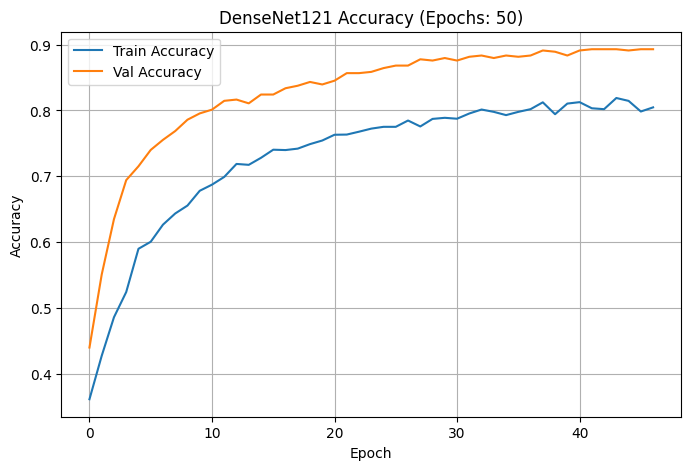

✅ DenseNet121 (50 Epochs) -> Train: 0.8744, Val: 0.8929, Test: 0.8805

🧠 Training ResNet50 for 50 epochs
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 522ms/step - accuracy: 0.3204 - loss: 1.4136 - val_accuracy: 0.2333 - val_loss: 1.1036
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step - accuracy: 0.3409 - loss: 1.2667 - val_accuracy: 0.4532 - val_loss: 1.0828
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 418ms/step - accuracy: 0.3633 - loss: 1.2020 - val_accuracy: 0.4799 - val_loss: 1.0648
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 425ms/step - accuracy: 0.3586 - loss: 1.1576 - val_accuracy: 0.6080 - val_loss: 1.0493
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 399ms/step - accuracy: 0.3808 - loss: 1.1172 - val_accuracy: 0.5736 - val_loss: 1.0375
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - accuracy: 0.4165 - loss: 1.0953 - val_accuracy: 0.6195 - val_loss: 1.0260
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.4141 - loss: 1.0635 - val_accuracy: 0.62

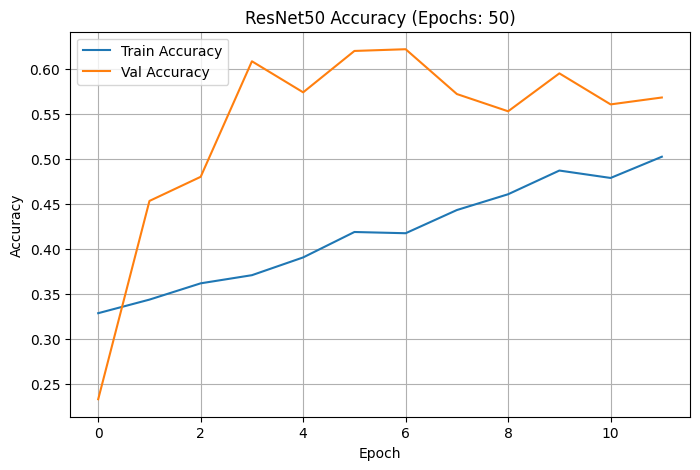

✅ ResNet50 (50 Epochs) -> Train: 0.5870, Val: 0.6214, Test: 0.5755

🧠 Training ResNet101 for 50 epochs
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 663ms/step - accuracy: 0.3311 - loss: 1.2979 - val_accuracy: 0.3327 - val_loss: 1.0921
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - accuracy: 0.3455 - loss: 1.2084 - val_accuracy: 0.5029 - val_loss: 1.0680
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 421ms/step - accuracy: 0.3587 - loss: 1.1776 - val_accuracy: 0.5660 - val_loss: 1.0540
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 429ms/step - accuracy: 0.3608 - loss: 1.1464 - val_accuracy: 0.5468 - val_loss: 1.0393
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 421ms/step - accuracy: 0.4099 - loss: 1.1000 - val_accuracy: 0.5602 - val_loss: 1.0275
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 448ms/step - accuracy: 0.3919 - loss: 1.0965 - val_accuracy: 0.5774 - val_loss: 1.0174
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 461ms/step - accuracy: 0.4230 - loss: 1.0668 - val_accuracy: 0.577

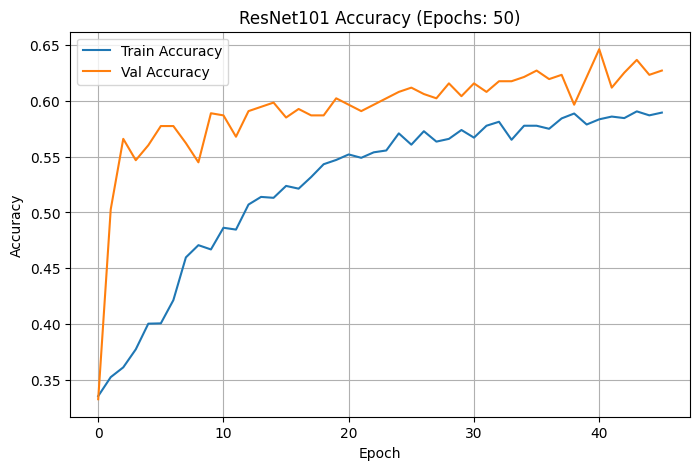

✅ ResNet101 (50 Epochs) -> Train: 0.6092, Val: 0.6463, Test: 0.6195

🧠 Training ResNet152 for 50 epochs
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 106s 667ms/step - accuracy: 0.3431 - loss: 1.5077 - val_accuracy: 0.3958 - val_loss: 1.0839
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - accuracy: 0.3402 - loss: 1.3408 - val_accuracy: 0.4417 - val_loss: 1.0769
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 57s 496ms/step - accuracy: 0.3445 - loss: 1.2767 - val_accuracy: 0.3958 - val_loss: 1.0696
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 55s 480ms/step - accuracy: 0.3771 - loss: 1.2157 - val_accuracy: 0.4398 - val_loss: 1.0612
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 444ms/step - accuracy: 0.3612 - loss: 1.1664 - val_accuracy: 0.3939 - val_loss: 1.0562
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 450ms/step - accuracy: 0.3807 - loss: 1.1463 - val_accuracy: 0.4818 - val_loss: 1.0507
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - accuracy: 0.3967 - loss: 1.1202 - val_accuracy: 0.44

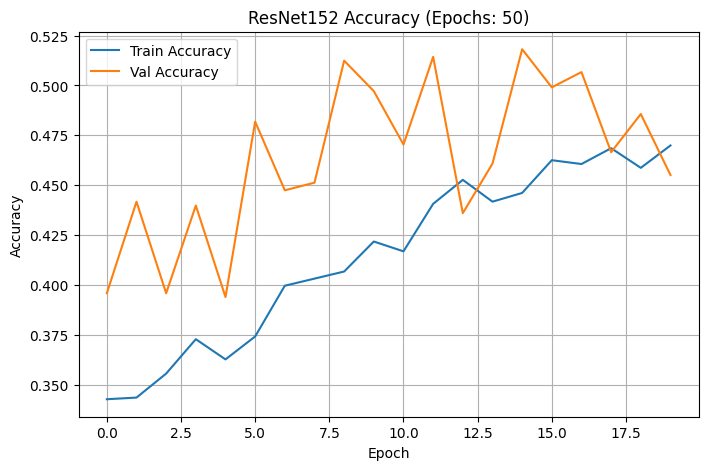

✅ ResNet152 (50 Epochs) -> Train: 0.5517, Val: 0.5182, Test: 0.5574

🧠 Training VGG16 for 50 epochs
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 518ms/step - accuracy: 0.3274 - loss: 1.2096 - val_accuracy: 0.4168 - val_loss: 1.0836
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - accuracy: 0.3641 - loss: 1.1360 - val_accuracy: 0.5124 - val_loss: 1.0562
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 429ms/step - accuracy: 0.3707 - loss: 1.1179 - val_accuracy: 0.5698 - val_loss: 1.0326
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.3968 - loss: 1.0862 - val_accuracy: 0.5946 - val_loss: 1.0115
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 421ms/step - accuracy: 0.4251 - loss: 1.0739 - val_accuracy: 0.6195 - val_loss: 0.9914
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 50s 437ms/step - accuracy: 0.4535 - loss: 1.0308 - val_accuracy: 0.6386 - val_loss: 0.9747
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 413ms/step - accuracy: 0.4894 - loss: 1.0205 - val_accuracy: 0.6539 - 

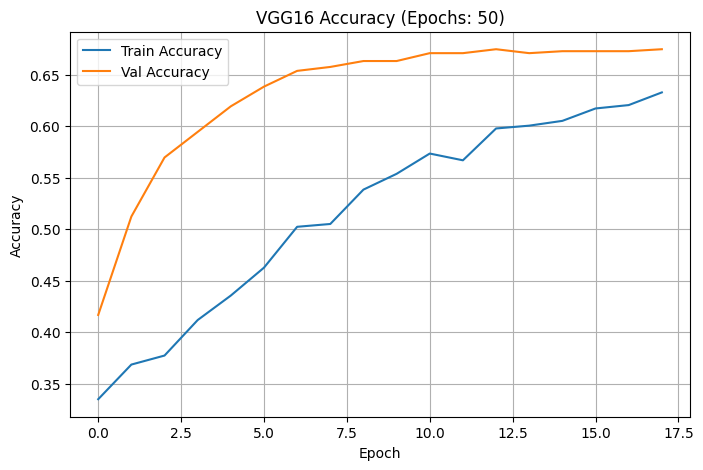

✅ VGG16 (50 Epochs) -> Train: 0.6765, Val: 0.6750, Test: 0.6769


In [9]:
results_50_epoch = {}

for name, base_model in models_to_train.items():
    print(f"\n🧠 Training {name} for 50 epochs")

    base_model.trainable = False

    model = build_model(base_model)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[es],
        verbose=1
    )

    # Accuracy Evaluation
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)

    results_50_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    # Plotting Accuracy
    plot_accuracy(history, name, 50)

    print(f"✅ {name} (50 Epochs) -> Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


In [12]:
import pandas as pd

# 📊 Convert results for 50 epochs into a DataFrame
df_50 = pd.DataFrame(results_50_epoch).T
df_50['Epochs'] = 50

# 🏷️ Reset index and rename it to 'Model'
df_50.reset_index(inplace=True)
df_50.rename(columns={'index': 'Model'}, inplace=True)

# 🔼 Sort by Test Accuracy (you can change this metric if needed)
sorted_df = df_50.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

# 📈 Final display
print("\n📈 Model Accuracy Summary (50 Epochs):")
print(sorted_df)



📈 Model Accuracy Summary (50 Epochs):
         Model  Train Accuracy  Val Accuracy  Test Accuracy  Epochs
0  DenseNet121           87.44         89.29          88.05      50
1        VGG16           67.65         67.50          67.69      50
2    ResNet101           60.92         64.63          61.95      50
3     ResNet50           58.70         62.14          57.55      50
4    ResNet152           55.17         51.82          55.74      50


**Using 2 more models**

In [15]:
# 📦 Import necessary libraries
from tensorflow.keras.applications import (
    DenseNet121, ResNet50, ResNet101, ResNet152, VGG16, EfficientNetB0
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 🔧 Initialize pre-trained models with ImageNet weights (excluding top layer)
models_to_train = {
    "DenseNet121": DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet101": ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet152": ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    # ⚠️ YOLOv5 is handled separately (not a Keras model)
    "YOLOv5": "Requires PyTorch / Ultralytics model loading"
}


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

results_60_epoch = {}

for name, base_model in models_to_train.items():
    print(f"\n🧠 Fine-tuning {name} for up to 60 epochs")

    # 🔓 Unfreeze base model for fine-tuning (optional: freeze lower half)
    for layer in base_model.layers[:len(base_model.layers)//2]:
        layer.trainable = False
    for layer in base_model.layers[len(base_model.layers)//2:]:
        layer.trainable = True

    # 🏗️ Build and compile the model
    model = build_model(base_model)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 🛑 EarlyStopping & 📉 Learning Rate Scheduler
    es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # 🚂 Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=60,
        callbacks=[es, lr_reduce],
        verbose=1
    )

    # 📊 Evaluate model on train/val/test
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)

    results_60_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    # 📈 Plot training curves
    plot_accuracy(history, name, 60)

    print(f"✅ {name} (Up to 60 Epochs) -> Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")



🧠 Fine-tuning DenseNet121 for up to 60 epochs
Epoch 1/60
 67/115 ━━━━━━━━━━━━━━━━━━━━ 18s 388ms/step - accuracy: 0.7604 - loss: 0.6939

**Train for 70 Epochs**


🧠 Fine-tuning DenseNet121 for up to 70 epochs
Epoch 1/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.7182 - loss: 0.7197 - val_accuracy: 0.9598 - val_loss: 0.1239 - learning_rate: 1.0000e-04
Epoch 2/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 55s 474ms/step - accuracy: 0.9625 - loss: 0.1104 - val_accuracy: 0.9866 - val_loss: 0.0314 - learning_rate: 1.0000e-04
Epoch 3/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 56s 490ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.9962 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 4/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 57s 497ms/step - accuracy: 0.9911 - loss: 0.0305 - val_accuracy: 0.9904 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 5/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 470ms/step - accuracy: 0.9985 - loss: 0.0075 - val_accuracy: 0.9885 - val_loss: 0.0352 - learning_rate: 1.0000e-04
Epoch 6/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 58s 505ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 1.0000e-04
E

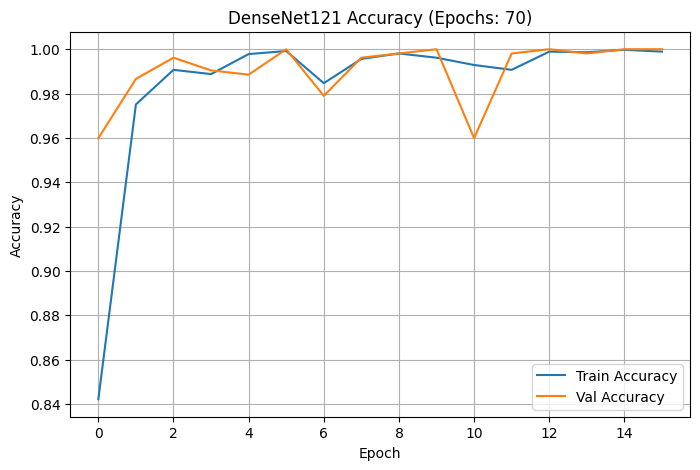

✅ DenseNet121 (Up to 70 Epochs) -> Train: 1.0000, Val: 1.0000, Test: 0.9971

🧠 Fine-tuning ResNet50 for up to 70 epochs
Epoch 1/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 162s 819ms/step - accuracy: 0.7905 - loss: 0.5143 - val_accuracy: 0.3327 - val_loss: 2.1469 - learning_rate: 1.0000e-04
Epoch 2/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 56s 485ms/step - accuracy: 0.9819 - loss: 0.0613 - val_accuracy: 0.3327 - val_loss: 1.3177 - learning_rate: 1.0000e-04
Epoch 3/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 466ms/step - accuracy: 0.9867 - loss: 0.0377 - val_accuracy: 0.3327 - val_loss: 1.7323 - learning_rate: 1.0000e-04
Epoch 4/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 466ms/step - accuracy: 0.9889 - loss: 0.0279 - val_accuracy: 0.3346 - val_loss: 2.2250 - learning_rate: 1.0000e-04
Epoch 5/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 467ms/step - accuracy: 0.9693 - loss: 0.0915 - val_accuracy: 0.3327 - val_loss: 6.9504 - learning_rate: 1.0000e-04
Epoch 6/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 85s 494ms/step - accuracy: 0.9941 - loss: 0.

KeyboardInterrupt: 

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

results_70_epoch = {}

for name, base_model in models_to_train.items():
    print(f"\n🧠 Fine-tuning {name} for up to 70 epochs")

    # 🔓 Unfreeze the base model for fine-tuning
    base_model.trainable = True

    # 🏗️ Build and compile model
    model = build_model(base_model)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 🛑 EarlyStopping & 📉 Learning Rate Scheduler
    es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=70,
        callbacks=[es, lr_reduce],
        verbose=1
    )

    # 📊 Evaluate on all sets
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)

    results_70_epoch[name] = {
        'Train Accuracy': round(train_acc * 100, 2),
        'Val Accuracy': round(val_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2)
    }

    # 📈 Plot training curves
    plot_accuracy(history, name, 70)

    print(f"✅ {name} (Up to 70 Epochs) -> Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


**Full Code to Create and Sort Accuracy Table**

In [13]:
import pandas as pd

# 🧾 Combine results into a DataFrame
df_15 = pd.DataFrame(results_15_epoch).T
df_15['Epochs'] = 15

df_30 = pd.DataFrame(results_30_epoch).T
df_30['Epochs'] = 30

df_50 = pd.DataFrame(results_50_epoch).T
df_50['Epochs'] = 50

# 🔗 Concatenate all results
combined_results = pd.concat([df_15, df_30, df_50], axis=0)
combined_results.reset_index(inplace=True)
combined_results.rename(columns={'index': 'Model'}, inplace=True)

# 🔼 Sort by Test Accuracy (or change to Val Accuracy/Train Accuracy if needed)
sorted_results = combined_results.sort_values(by='Test Accuracy', ascending=True).reset_index(drop=True)

# 🎯 Display the final sorted table
print(sorted_results)


NameError: name 'results_15_epoch' is not defined

**Save the Best Model (.h5 or .pkl)**

**👉 For Keras / TensorFlow models:**

In [14]:
from tensorflow.keras.models import save_model

# Save the model in .h5 format
model.save("best_liver_model.h5")


**👉 For .pkl (Usually for sklearn-based models):**

In [ ]:
#import joblib

# joblib.dump(model, 'model.pkl')  # use only for sklearn models, not TensorFlow
